In [1]:
import numpy as np
from python.analysis import Plots
Plots.plt.style.use("default")
Plots.plt.style.use("ggplot")

Measueing pi:

The definition for the area of a circle is

$$
A_{c} = \pi r_{c}^{2}
$$

so by measuring $r_{c}$ and $A_{c}$ you can compute $\pi$. to measure the area one would use the formula, but instead we can look at the problem in a different way. Let us compare the ratio of the square  with $r_{s}$ to a circe:

$$
R = \frac{\pi r_{c}^{2}}{r_{s}^2}
$$

and when $r_{s}$ = $r_{c}$, $R = \pi$. To indirectly measure this ratio we can do the following:
 - create a target with a circle overlapping a sqaure with $r_{s} = 2 r_{c}$.
 - throw darts randomly at the target
 - count the number of darts which are in the circle and count the number in the square, and the ratio of these numbers are directly proportional to the $R$.

Note now because $r_{s} = 2 r_{c}$ the equation is modified:

$$
R = \frac{4\pi r_{c}^{2}}{r_{s}^2}
$$


In [2]:
def count_in_circle(throws, r_c):
    r = (throws[0]**2 + throws[1]**2)**2
    return sum(r < r_c)


def count_in_square(throws, r_s):
    return sum((throws[0] < r_s) & (throws[1] < r_s))


def R(throws, r_s, r_c):
    return 4 * count_in_circle(throws, r_c)/count_in_square(throws, r_s)


def sigma_r_stat(throws, r_s, r_c):
    n_c = count_in_circle(throws, r_c)
    n_s = count_in_square(throws, r_s)
    return 4* n_c/n_s * (1/n_c + 1/n_s)**0.5

In [3]:
def throw_bias(x, y):
    return [[x], [y]]

In [4]:
r_s = 2
r_c = 1
n_throws = 1000

bx = -0.75
by = 0.75

throws = r_s * (np.random.random([2, n_throws]) - 0.5) + throw_bias(bx, by) # where did the dart land

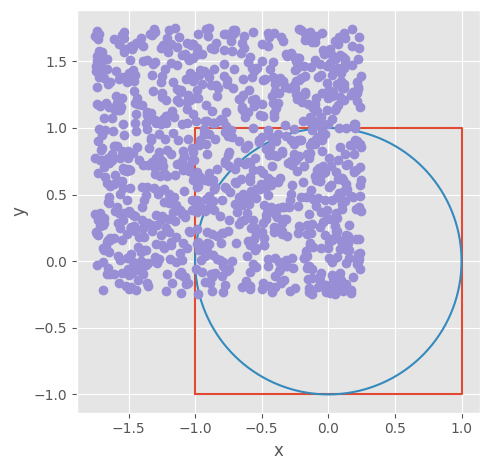

In [5]:
def visualise():
    Plots.Plot(np.array([-0.5, 0.5, 0.5, -0.5, -0.5])*r_s, np.array([-0.5, -0.5, 0.5, 0.5, -0.5])*r_s, xlabel = "x", ylabel = "y")
    theta = np.linspace(0, 2* np.pi, 1000)
    Plots.Plot(r_c * np.sin(theta), r_c * np.cos(theta), newFigure = False)
    Plots.Plot(throws[0], throws[1], marker = "o", linestyle = "", newFigure = False)
    Plots.plt.gca().set_aspect('equal')
    return

visualise()

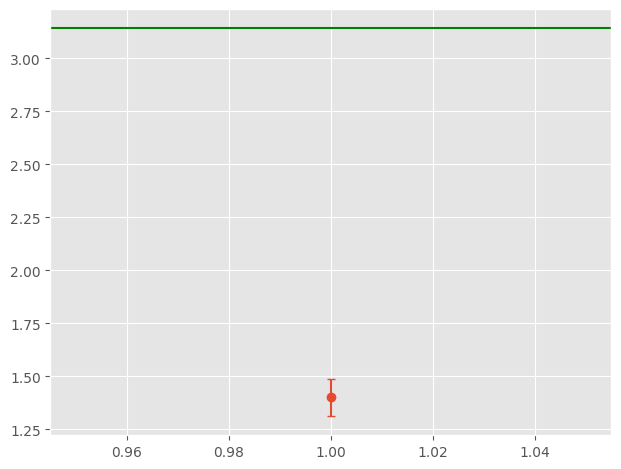

In [6]:
r = R(throws, r_s, r_c)
sigma_r = sigma_r_stat(throws, r_s, r_c)

Plots.Plot(1, r, yerr = sigma_r, marker = "o")
Plots.plt.axhline(np.pi, color = "green")

# Estimate bias in the throws

In [7]:
def estimate_bias(x):
    return np.mean(x), np.std(x)/(len(x - 1))**0.5

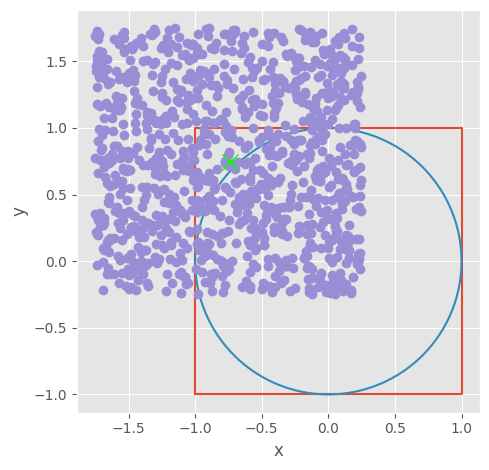

In [8]:
est_bias_x  = estimate_bias(throws[0])
est_bias_y  = estimate_bias(throws[1])
visualise()
Plots.Plot(est_bias_x[0], est_bias_y[0], xerr = est_bias_x[1], yerr = est_bias_y[1], newFigure = False, marker = "x", color = "lime", markersize = 12)

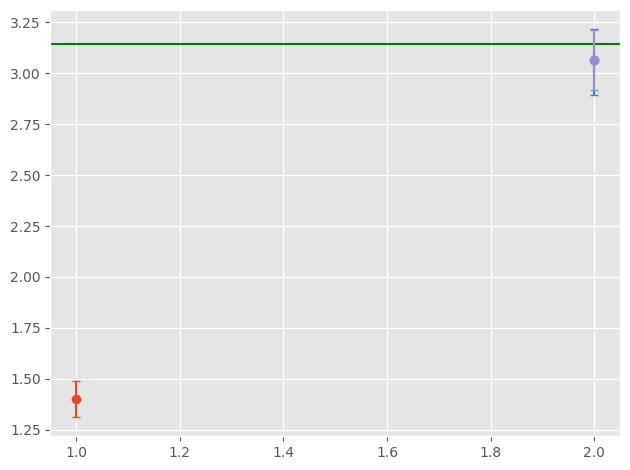

In [9]:
bias_corrected_r = R(throws - throw_bias(est_bias_x[0], est_bias_y[0]), r_s, r_c)
sigma_bias_corrected_r_stat = sigma_r_stat(throws - throw_bias(est_bias_x[0], est_bias_y[0]), r_s, r_c) # this sigma will change based on the upper and lower bounds as well...
bias_corrected_r_upper = R(throws - throw_bias(est_bias_x[0] + est_bias_x[1], est_bias_y[0] + est_bias_y[1]), r_s, r_c)
bias_corrected_r_lower = R(throws - throw_bias(est_bias_x[0] - est_bias_x[1], est_bias_y[0] - est_bias_y[1]), r_s, r_c)


Plots.Plot(1, r, yerr = sigma_r, marker = "o")
Plots.plt.axhline(np.pi, color = "green")
Plots.Plot(2, bias_corrected_r, yerr = [ [sigma_bias_corrected_r_stat + abs(bias_corrected_r - bias_corrected_r_lower)], [sigma_bias_corrected_r_stat + abs(bias_corrected_r - bias_corrected_r_upper)]], marker = "o", newFigure = False)
Plots.Plot(2, bias_corrected_r, yerr = sigma_bias_corrected_r_stat, marker = "o", newFigure = False)


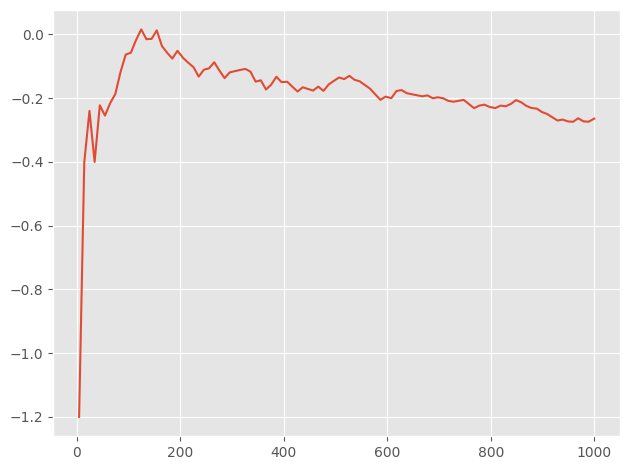

In [10]:
corrected_throws = throws - throw_bias(est_bias_x[0], est_bias_y[0])
bias_corrected_r = R(corrected_throws[:, 0:10], r_s, r_c)

n = np.linspace(5, len(corrected_throws[0]), 100, dtype = int)
out = []
for i in n:
    out.append(abs(bias_corrected_r) - R(corrected_throws[:, 0:i], r_s, r_c))

Plots.Plot(n, out)

# Fischer discriminant

In [11]:
class Fischer:
    def __init__(self, x1, x2):
        self.x1 = x1
        self.x2 = x2

    def Run(self, c1, cutsom_offset : float = 0):
        mu1 = np.array([np.mean(self.x1[c1]), np.mean(self.x2[c1])])
        mu2 = np.array([np.mean(self.x1[~c1]), np.mean(self.x2[~c1])])

        cov1 = np.cov([self.x1[c1], self.x2[c1]])
        cov2 = np.cov([self.x1[~c1], self.x2[~c1]])

        w = np.matmul(np.linalg.inv(cov1 + cov2), (mu1 - mu2))

        f = (w[0] * self.x1) + (w[1] * self.x2)
        w0 = np.median(f) + cutsom_offset
        f -= w0
        f_efficiency = sum((f > 0) == c1) / len(c1)

        print(f"{w=}")
        print(f"{w0=}")
        print(f"{f_efficiency=}")

        x = np.linspace(np.min(self.x1), np.max(self.x1), 10)
        Plots.Plot(x, 0.5 + 2 * x, color = "black", linestyle = "--", label = "exact")

        Plots.Plot(self.x1[c1], self.x2[c1], newFigure = False, marker = "o", linestyle = "", markersize = 3, xlabel = "x1", ylabel = "x2", alpha = 0.5, label = "A")
        Plots.Plot(self.x1[~c1], self.x2[~c1], newFigure = False, marker = "o", linestyle = "", markersize = 3, alpha = 0.5, label = "B")

        Plots.Plot(mu1[0], mu1[1], newFigure = False, marker = "X", linestyle = "", color = "C0", markersize = 12, label = "$\mu_{A}$")
        Plots.Plot(mu2[0], mu2[1], newFigure = False, marker = "X", linestyle = "", color = "C1", markersize = 12, label = "$\mu_{B}$")

        Plots.Plot(self.x1[c1], f[c1], marker = "o", linestyle = "", xlabel = "x1", ylabel = "F", markersize = 3)
        Plots.Plot(self.x1[~c1], f[~c1], newFigure = False, marker = "o", linestyle = "", markersize = 3)
        Plots.plt.axhline(0, label = "Fischer cut", color = "black", linestyle = "--")
        return

In [12]:
n = int(1E4)
x1 = np.random.normal(0, 1, n)
x2 = np.random.normal(0, 3, n)

w=array([ 1.25205094, -0.62119287])
w0=0.030460183391668283
f_efficiency=0.9344


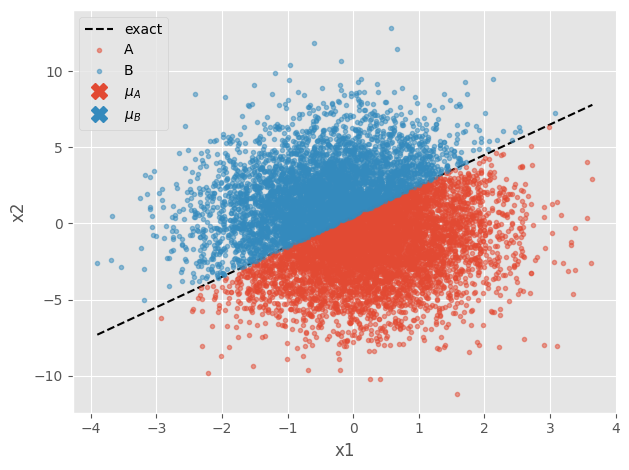

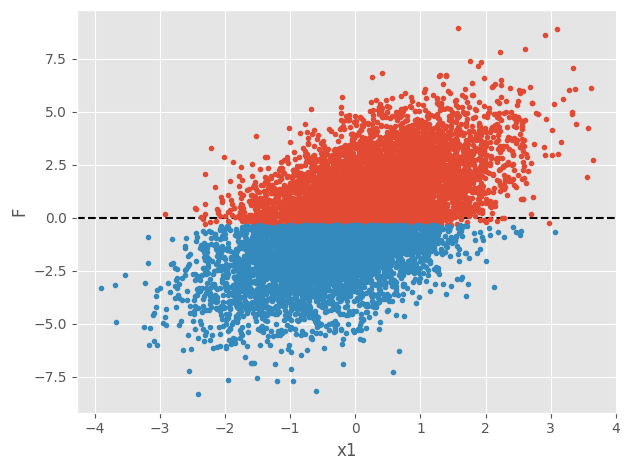

In [13]:
c1 = (-2 * x1 + x2) < 0.5 #* use fischer discriminant for this case!
fischer = Fischer(x1, x2)
fischer.Run(c1)

w=array([1.27114477, 0.33625633])
w0=-0.029149551577231814
f_efficiency=0.6293


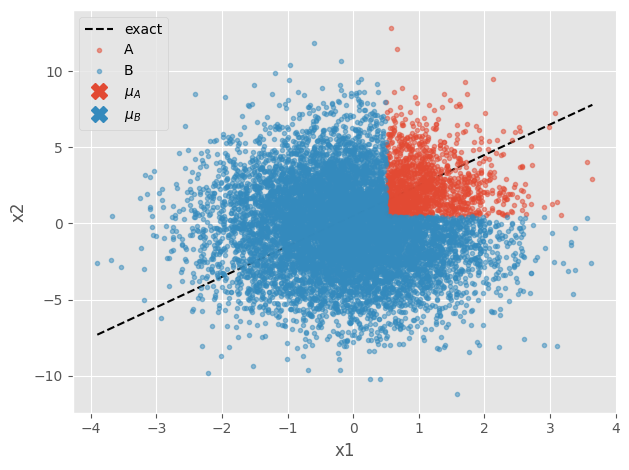

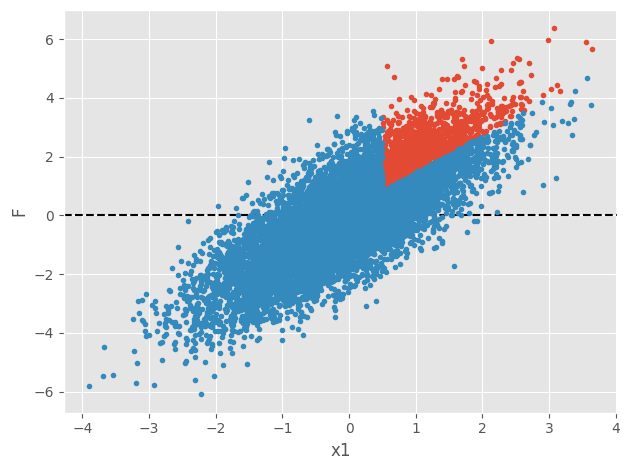

In [14]:
c1 = (x1 > 0.5) & (x2 > 0.5) #! don't use fischer discriminant for this case!
fischer = Fischer(x1, x2)
fischer.Run(c1)

# ABCD background subtraction

$$
N^{b}_{D} = N^{b}_{B}\frac{N^{b}_{C}}{N^{b}_{A}}
$$

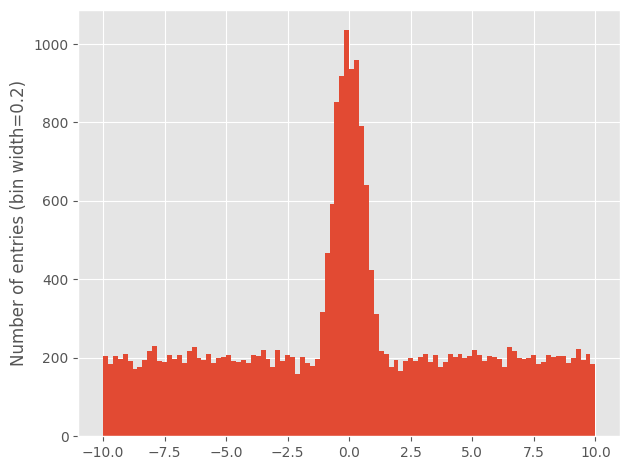

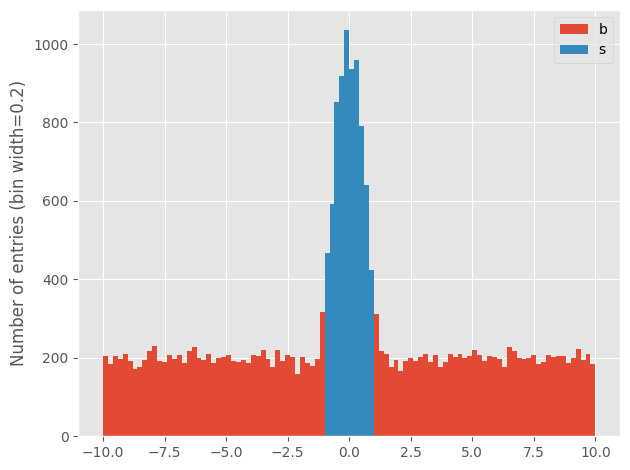

In [15]:
n = int(1E5)

def g(x):
    return np.exp(-x**2)

def u(x):
    return [0.2]*len(x)

x = np.random.uniform(-10, 10, n)
p = np.random.random(n)
a = (p < g(x)) | (p < u(x))
d = x[a]


q1, q2 = np.random.randint(0, 2, [len(d), 2], dtype = bool).T # tagging events

def regions():
    return {"A" : (q1 == 0) & (q2 == 0), "B" : (q1 == 0) & (q2 == 1), "C" : (q1 == 1) & (q2 == 0), "D" : (q1 == 1) & (q2 == 1)}


s = abs(d) < 1
Plots.PlotHist(d)
Plots.PlotHist([d[~s], d[s]], label = ["b", "s"], stacked = True)
r = regions()

0 A
[ 0.48482628  0.34446126 -0.44649947 ...  0.21619913 -0.31496064
  0.68179428]
1 B
[-0.78006616 -0.28983183  0.08616165 ...  0.39950184 -0.2928465
 -0.19843496]
2 C
[-0.85105047  0.0454066  -0.28176281 ...  0.36709506 -0.89630207
  0.92535641]
3 D
[ 0.06469046  0.35519065  0.26357262 ... -0.7385379   0.09264375
  0.73337774]


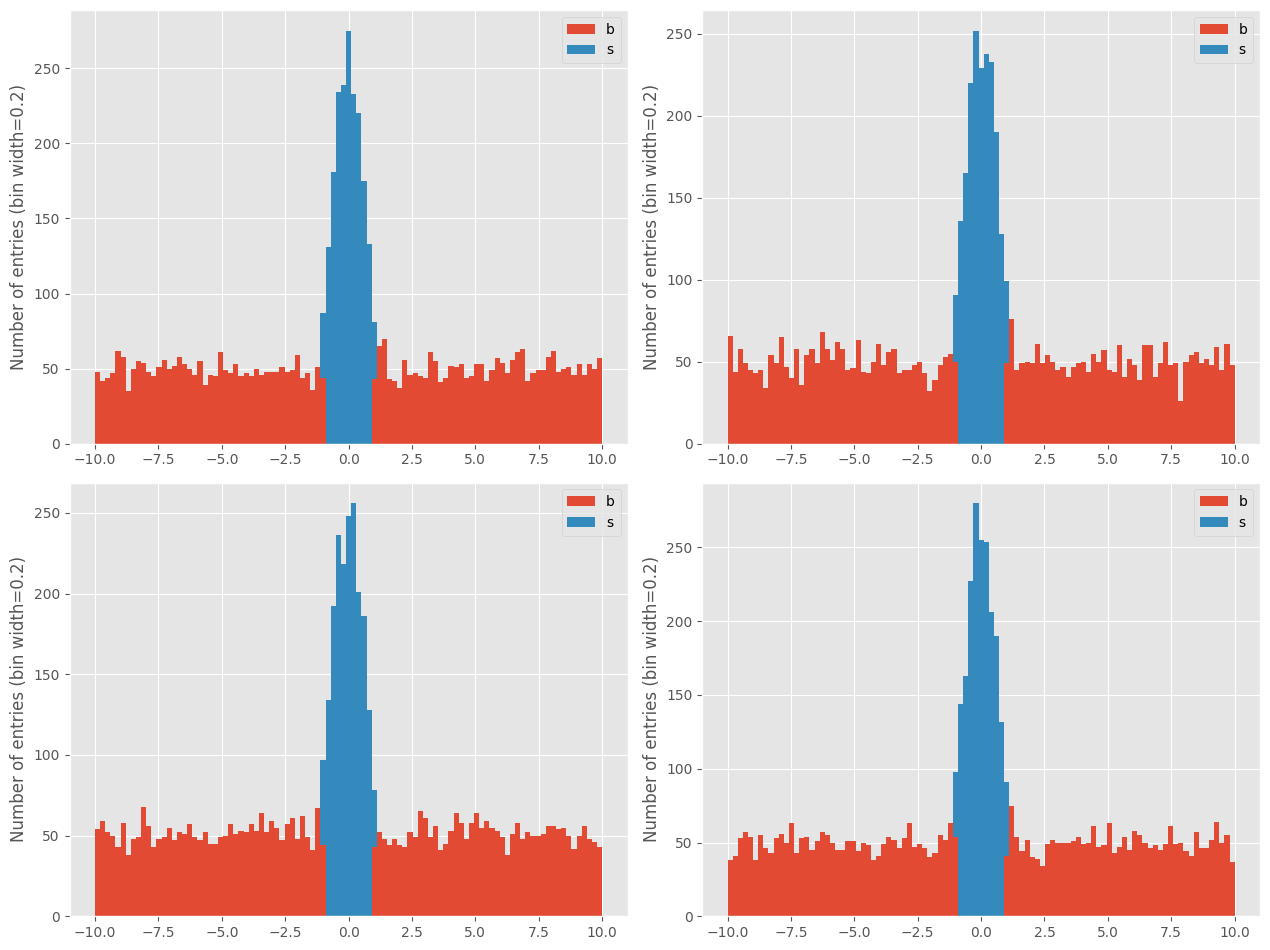

In [16]:
bins = np.linspace(-10, 10, 100) # fix the binning

for i, j in Plots.IterMultiPlot(r):
    print(i, j)
    print(d[r[j] & s])
    Plots.PlotHist([d[r[j] & ~s], d[r[j] & s]], label = ["b", "s"], bins = bins, stacked = True, newFigure = False)


# estimate backgrounds

{'A': (48.96052631578947, 1.0162609123254671), 'B': (49.0921052631579, 1.2247703159653265), 'C': (50.81578947368421, 1.0963592903077606), 'D': (50.952354347303356, 1.9856739290522063)}


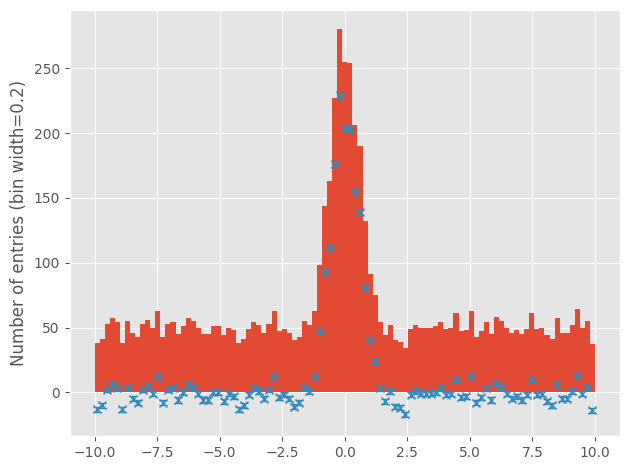

In [18]:
def estimate_background(data):
    background = abs(data) > 2.5
    counts = np.histogram(data[background], bins)[0]
    counts = counts[counts != 0]
    return np.mean(counts), np.std(counts) / np.sqrt(len(counts)-1) 


def ABCD_method(data, reg):
    n_b = {i : estimate_background(data[reg[i]]) for i in ["A", "B", "C"]}

    n_D = (n_b["C"][0]/n_b["A"][0]) * n_b["B"][0] # ABCD subtraction

    n_D_e = n_D * sum([(n_b[i][1]/n_b[i][0])**2 for i in ["A", "B", "C"]])**0.5
    n_b["D"] = (n_D, n_D_e)
    print(n_b)
    return n_b["D"]

n_background = ABCD_method(d, r)
signal_data_hist = np.histogram(d[r["D"]], bins = bins)

centers = (signal_data_hist[1][1:] + signal_data_hist[1][:-1]) / 2

Plots.PlotHist(d[r["D"]], bins = bins)
Plots.Plot(centers, signal_data_hist[0] - n_background[0], yerr = n_background[1], newFigure = False, marker = "x", linestyle = "")

# Plots.plt.hist(signal_data_hist[1][:-1], bins = signal_data_hist[1], weights = signal_data_hist[0] - n_background[0])


# pyhf

In [2]:
import json
import pyhf
import numpy as np
from python.analysis import Plots
from python.analysis.cross_section import SetPlotStyle
from rich import print
import os
from pathos.pools import ProcessPool

SetPlotStyle(True, 100)
pyhf.set_backend(backend = "numpy", custom_optimizer = "minuit")

def MakePull(model, observations, normalisation):
    result = Fit(observations, model, verbose = False)
    return ((normalisation * result[0:4, 0]) - 1) / (normalisation * result[0:4, 1])


def CalculatePulls(n_experiments, n_regions, model, max_cpu : int = os.cpu_count()-2):

    batches = int(n_experiments/max_cpu)
    remainder = n_experiments % max_cpu

    pulls = []
    for i in range(batches + 1):
        if i == batches:
            cpus = remainder
        else:
            cpus = max_cpu
        if cpus == 0: continue
        pools = ProcessPool(nodes = cpus)
        observations = [GenerateObservations(CreateDataSet(12, n_regions, n_background, 2500, bins), n_regions, model, verbose = False) for i in range(cpus)]
        pulls.extend(pools.map(MakePull, observations))
    return np.array(pulls)


def CreateDataSet(seed : int, n_regions : int, n_background : int, n_data : int, bins : list):
    rng = np.random.default_rng(seed)
    mu =    [0, 0.5, 1, 2]
    sigma = [1, 0.5, 3, 1.4]
    # mu = rng.random()
    # sigma = rng.random()

    sample_fractions = rng.random(size = [n_regions, n_background + 1])
    sample_fractions = sample_fractions / np.sum(sample_fractions, axis = 1)[:, np.newaxis]
   
    output = {}
    for i in range(n_regions):
        output[f"region_{i}"] = [np.random.normal(mu[j], sigma[j], int(n_data * sample_fractions[i][j])) for j in range(n_background + 1)]
        output[f"region_{i}_binned"] = [np.histogram(i, bins = bins)[0] for i in output[f"region_{i}"]]
        output[f"region_{i}_combined"] = np.sum(output[f"region_{i}_binned"], axis = 0)

    return output


def CreateModel(channels : int, samples_binned, mc_stat_unc : bool = False):
    def channel(num : int, samples : np.array):
        channel = {
            "name": f"channel_{num}",
            "samples":[
                {
                    "name" : f"sample_{i}",
                    "data" : s,
                    "modifiers" : [
                        {'name': f"mu_{i}", 'type': 'normfactor', 'data': None},
                        ]
                }
            for i, s in enumerate(samples)
            ]
        }
        if mc_stat_unc == True:
            for i in range(len(samples)):
                channel["samples"][i]["modifiers"].append({'name': f"sample_stat_err_{i}", 'type': 'staterror', 'data': np.sqrt(samples[i])})

        return channel
    spec = {"channels" : [channel(n, samples_binned[n]) for n in range(channels)]}
    model = pyhf.Model(spec, poi_name = "mu_0")
    return model


def PrintModelSpecs(model):
    print(f"  channels: {model.config.channels}")
    print(f"     nbins: {model.config.channel_nbins}")
    print(f"   samples: {model.config.samples}")
    print(f" modifiers: {model.config.modifiers}")
    print(f"parameters: {model.config.parameters}")
    print(f"  nauxdata: {model.config.nauxdata}")
    print(f"   auxdata: {model.config.auxdata}")


def GenerateObservations(data, n_regions, model, verbose : bool = True):
    if verbose is True: print(f"{model.config.suggested_init()=}")
    observations = np.concatenate([data[f"region_{n}_combined"] for n in range(n_regions)] + [model.config.auxdata])
    if verbose is True: print(f"{model.logpdf(pars=model.config.suggested_init(), data=observations)=}")
    return observations


def Fit(observations, model, verbose : bool = True):
    result = pyhf.infer.mle.fit(data=observations, pdf=model, return_uncertainties = True)
    if verbose is True: print(f"{model.config.poi_index=}")
    if verbose is True: print(f"{result=}")
    return result


def PlotSignal(data, n_regions, result, model):
    mu = result[model.config.poi_index]
    print(f"{mu=}")
    centers = (bins[1:] + bins[:-1])/2

    for n in Plots.MultiPlot(n_regions):
        Plots.PlotHist(data[f"region_{n}"], stacked = True, bins = bins, newFigure = False)
        Plots.Plot(centers, mu[0] * model.spec["channels"][n]["samples"][0]["data"], yerr = mu[1] * model.spec["channels"][n]["samples"][0]["data"], color = "black", marker = "x", linestyle = "", newFigure = False)


def MakePlots(data, result, n_regions, n_background, model):
    config_order = {"mu" : 0}
    config_order.update({f"bkg_{i}" : i + 1 for i in range(n_background)})
    for n in Plots.MultiPlot(n_regions):
        Plots.PlotHist(data[f"region_{n}"], stacked = True, bins = bins, label = [f"mc:{i}" for i in config_order], newFigure = False)
        counts = np.zeros(len(bins) - 1)
        for p in config_order:
            model_index = model.config.par_map[p]["slice"].start
            config_index = config_order[p]
            counts = counts + model.spec["channels"][n]["samples"][config_index]["data"]
            Plots.Plot(centers, result[model_index][0] * counts, yerr = result[model_index][1] * counts, label = f"data:{p}", marker = "x", linestyle = "", newFigure = False)

# simple example

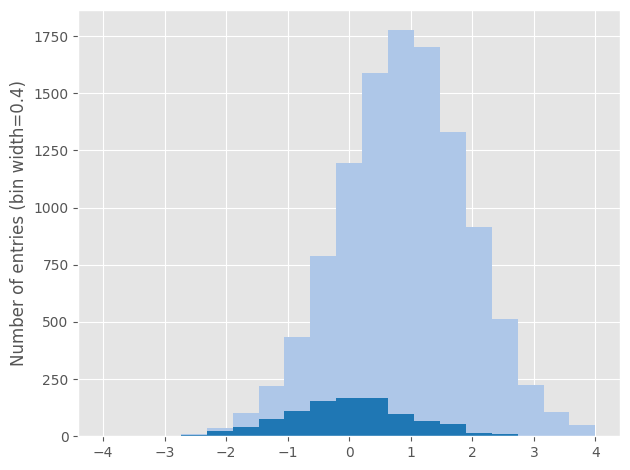

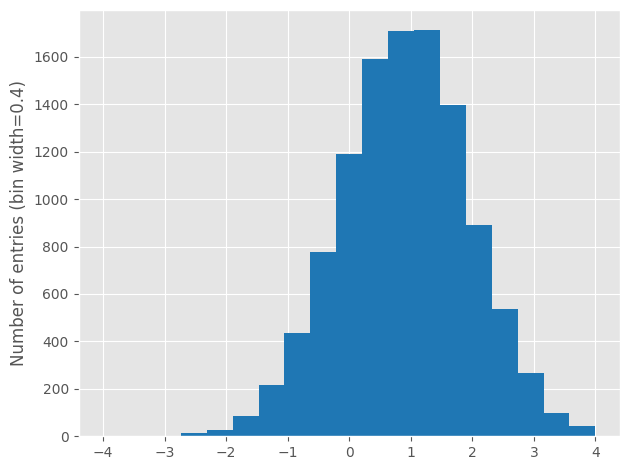

In [32]:
data = [np.random.normal(0, 1, 1000), np.random.normal(1, 1, 10000)]
observed = [np.random.normal(0, 1, 1000), np.random.normal(1, 1, 10000)] # in reality Data would be normalised to MC, so total counts will be equal. 

norm = len(np.concatenate(data))/len(np.concatenate(observed))

bins = np.linspace(-4, 4, 20)

Plots.PlotHist(data, stacked = True, bins = bins)
Plots.PlotHist(np.concatenate(observed), bins = bins)

data_binned = [np.histogram(data[0], bins = bins)[0], np.histogram(data[1], bins = bins)[0]]
observed_binned_cheat = [np.histogram(observed[0], bins = bins)[0], np.histogram(observed[1], bins = bins)[0]]
observed_binned = np.histogram(np.concatenate(observed), bins = bins)[0]

In [33]:
model = pyhf.simplemodels.uncorrelated_background(
    signal=data_binned[0], bkg=data_binned[1], bkg_uncertainty=np.sqrt(data_binned[1])
)
print(model.spec)

{
    'channels': [
        {
            'name': 'singlechannel',
            'samples': [
                {
                    'name': 'signal',
                    'data': array([  1,   1,   2,   6,  21,  42,  76, 112, 153, 169, 169,  97,  68,
        55,  16,   9,   3,   0,   0]),
                    'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None}]
                },
                {
                    'name': 'background',
                    'data': array([   0,    0,    1,    2,   15,   59,  142,  321,  635, 1025, 1420,
       1678, 1633, 1276,  898,  502,  220,  107,   48]),
                    'modifiers': [
                        {
                            'name': 'uncorr_bkguncrt',
                            'type': 'shapesys',
                            'data': array([ 0.        ,  0.        ,  1.        ,  1.41421356,  3.87298335,
        7.68114575, 11.91637529, 17.91647287, 25.19920634, 32.01562119,
       37.68288736, 40.9633983 , 40.4103947 , 35.7211422 , 29.96664813,
       22.4053565 , 14.83239697, 10.34408043,  6.92820323])
                        }
                    ]
                }
            ]
        }
    ]
}

In [34]:
print(f"  channels: {model.config.channels}")
print(f"     nbins: {model.config.channel_nbins}")
print(f"   samples: {model.config.samples}")
print(f" modifiers: {model.config.modifiers}")
print(f"parameters: {model.config.parameters}")
print(f"  nauxdata: {model.config.nauxdata}")
print(f"   auxdata: {model.config.auxdata}")

channels: ['singlechannel']

nbins: {'singlechannel': 19}

samples: ['background', 'signal']

modifiers: [('mu', 'normfactor'), ('uncorr_bkguncrt', 'shapesys')]

parameters: ['mu', 'uncorr_bkguncrt']

nauxdata: 19

auxdata: [1.0, 1.0, 1.0, 1.9999999999999996, 14.999999999999998, 59.00000000000001, 142.0, 321.0, 635.0, 1025.0,
1419.9999999999998, 1678.0, 1633.0000000000002, 1276.0000000000002, 898.0, 502.0, 220.0, 106.99999999999999, 
48.00000000000001]

In [35]:
print(model.config.suggested_init())
observations = np.concatenate([observed_binned, model.config.auxdata])
print(model.logpdf(pars=model.config.suggested_init(), data=observations))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

[-138.08630362]

In [36]:
result = pyhf.infer.mle.fit(data=observations, pdf=model)
print(model.config.poi_index)
print(result)

0

[0.90600758 1.         1.         1.05042395 1.62126524 0.84671681
 0.91810723 1.01178882 1.01959998 1.00383473 1.00540487 1.00665032
 0.98292207 1.00522661 1.02696501 0.98758449 1.02453385 1.09781611
 0.95794697 0.95833677]

0.906007578038942

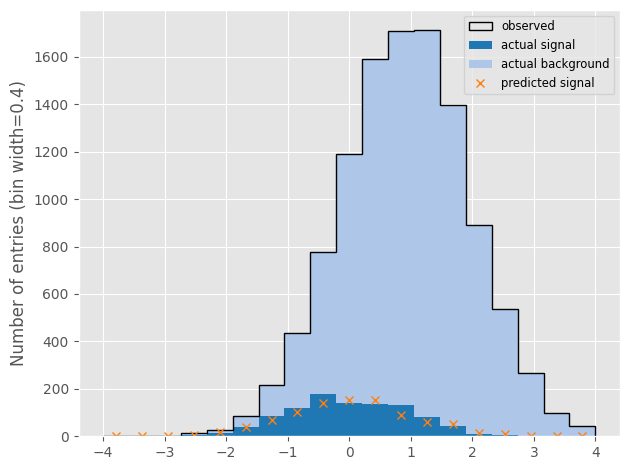

In [37]:
mu = result[model.config.poi_index]
print(mu)
centers = (bins[1:] + bins[:-1])/2

Plots.PlotHist(np.concatenate(observed), bins, histtype = "step", color = "black", label = "observed")
Plots.PlotHist(observed, bins, stacked = True, newFigure = False, label = ["actual signal", "actual background"])
Plots.Plot(centers, mu * data_binned[0], newFigure = False, linestyle = "", marker = "x", label = "predicted signal")


# background strength

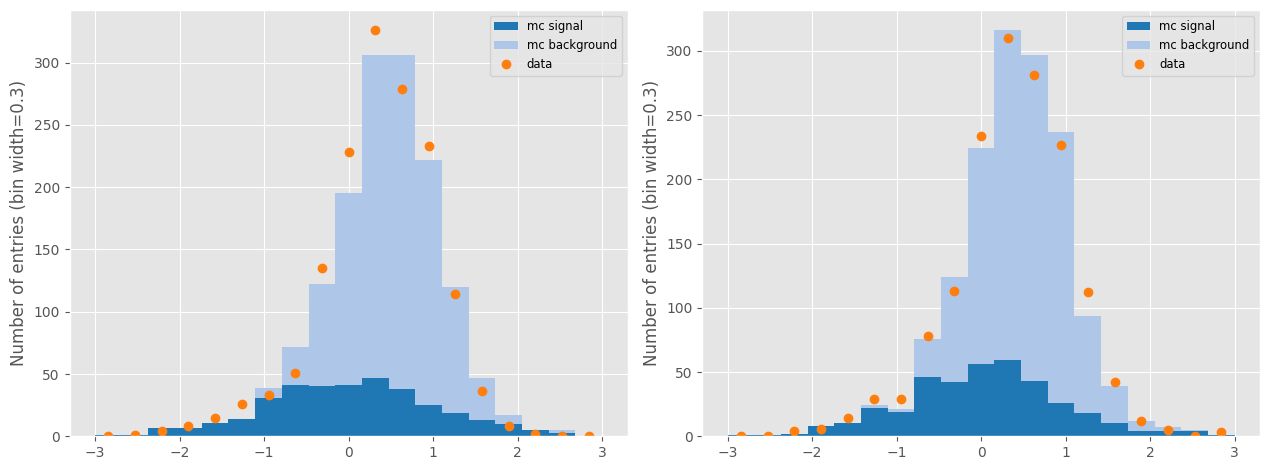

In [46]:
def channel(num : int, signal_data : np.array, background_data : np.array):
    return {
        "name": f"channel_{num}",
        "samples":[
            {
                "name" : "signal",
                "data" : signal_data,
                "modifiers" : [{'name': "mu", 'type': 'normfactor', 'data': None}]
            },
            {
                "name" : f"background_{num}",
                "data" : background_data,
                "modifiers" : [{'name': f"bkg_{num}", 'type': 'normfactor', 'data': None}]
            },
            
        ],
    }

bins = np.linspace(-3, 3, 20)
centers = (bins[1:] + bins[:-1])/2

n_regions = 2
mc = CreateDataSet(250, n_regions, 1, 1500, bins)
data = CreateDataSet(250, n_regions, 1, 1500, bins)

for n in Plots.MultiPlot(n_regions):
    Plots.PlotHist(mc[f"region_{n}"], bins = bins, stacked = True, label = ["mc signal", "mc background"], newFigure = False)
    Plots.Plot(centers, data[f"region_{n}_combined"], marker = "o", linestyle = "", label = "data", newFigure = False)

spec = {"channels" : [
    channel(n, mc[f"region_{n}_binned"][0], mc[f"region_{n}_binned"][1])
    for n in range(n_regions)]}
model = pyhf.Model(spec = spec)

In [47]:
PrintModelSpecs(model)

channels: ['channel_0', 'channel_1']

nbins: {'channel_0': 19, 'channel_1': 19}

samples: ['background_0', 'background_1', 'signal']

modifiers: [('bkg_0', 'normfactor'), ('bkg_1', 'normfactor'), ('mu', 'normfactor')]

parameters: ['bkg_0', 'bkg_1', 'mu']

nauxdata: 0

auxdata: []

In [48]:
observations = GenerateObservations(data, n_regions, model)

model.config.suggested_init()=[1.0, 1.0, 1.0]

model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-128.07390116])

model.config.poi_index=1

result=array([[1.00475861, 0.03629033],
       [1.02150573, 0.07193084],
       [0.98302814, 0.03791597]])

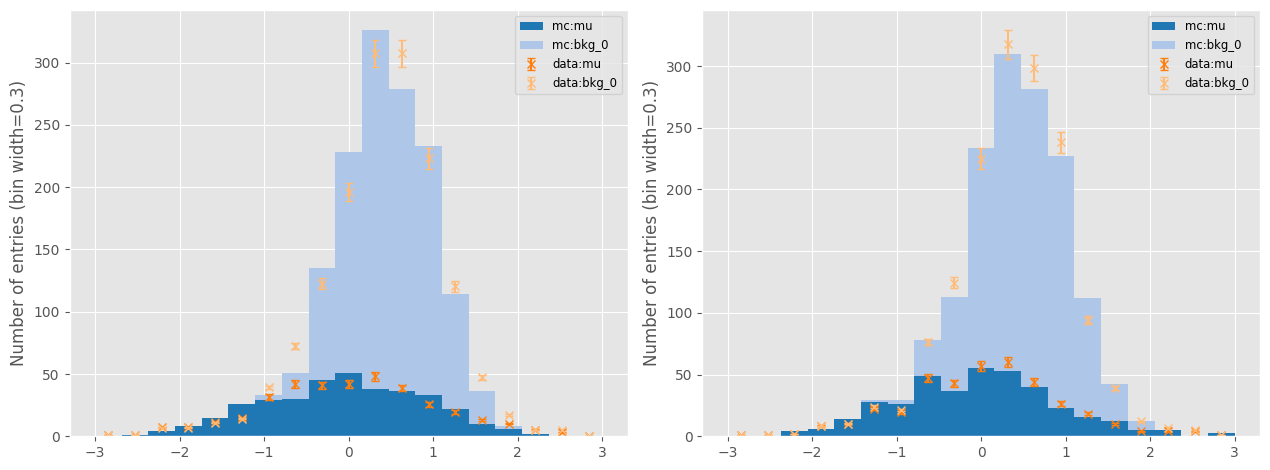

In [49]:
result = Fit(observations, model)
MakePlots(data, result, n_regions, 1, model)

# multiple backgrounds

400.0

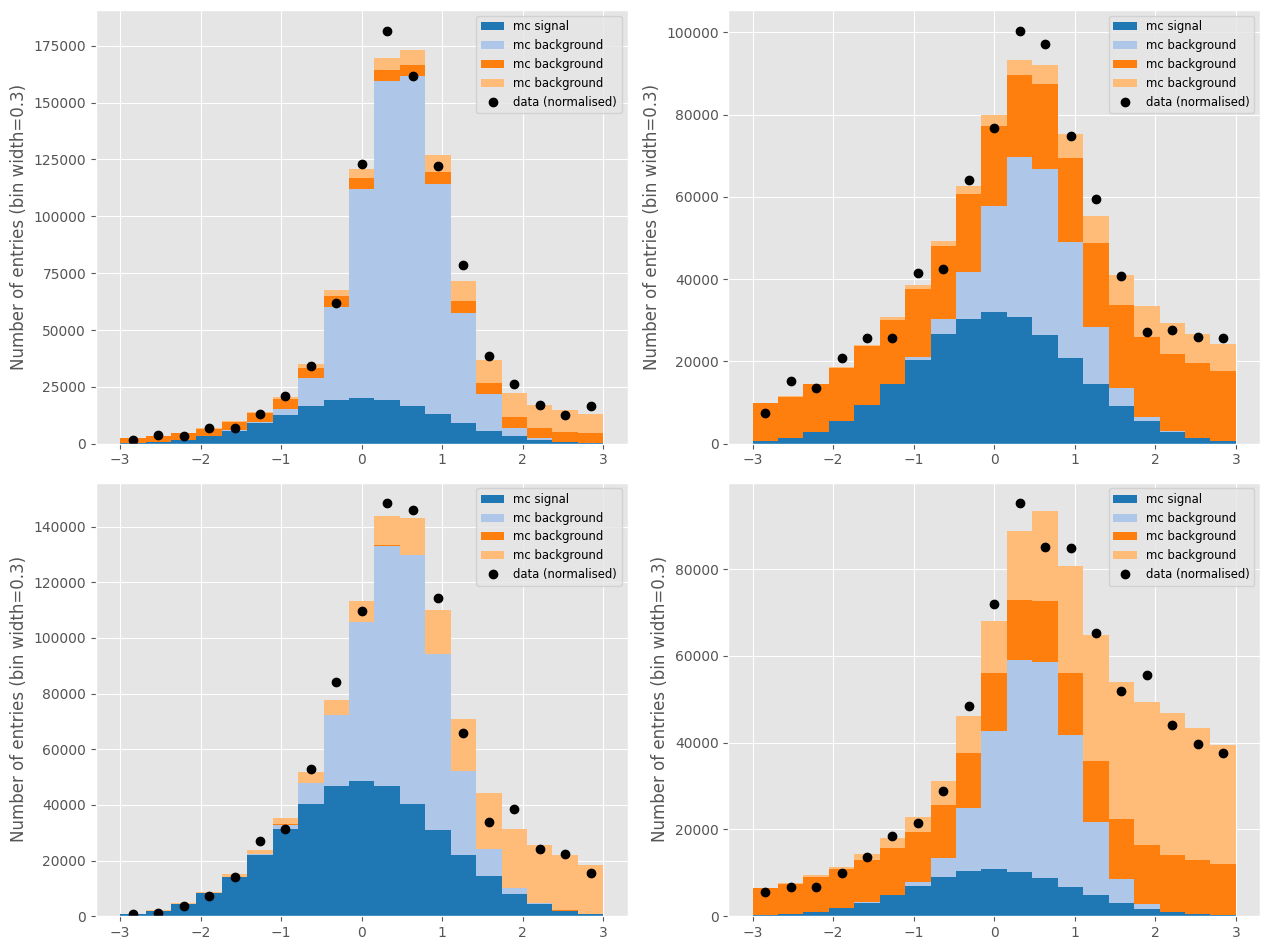

In [52]:
def channel(num : int, signal_data : np.array, background_data : list[np.array]):
    return {
        "name": f"channel_{num}",
        "samples":[
            {
                "name" : "signal",
                "data" : signal_data,
                "modifiers" : [
                    {'name': "mu", 'type': 'normfactor', 'data': None},
                    # {
                    #     "name": "mu_err",
                    #     "type": "normsys",
                    #     "data": {"hi": 0.9, "lo": 1.1},
                    # }
                    # {'name': f"sig_stat_err_{num}", 'type': 'staterror', 'data': np.sqrt(signal_data)}
                    ]
            },
        ]+[
            {
                "name" : f"background_{num}_{b}",
                "data" : background_data[b],
                "modifiers" : [
                    {'name': f"bkg_{b}", 'type': 'normfactor', 'data': None},
                    # {
                    #     "name": f"bkg_err_{b}",
                    #     "type": "normsys",
                    #     "data": {"hi": 0.9, "lo": 1.1},
                    # }
                    # {'name': f"bkg_stat_err_{num}_{b}", 'type': 'staterror', 'data': np.sqrt(background_data[b])}
                    ]
            }
        for b in range(len(background_data))
        ]
    }

bins = np.linspace(-3, 3, 20)
centers = (bins[1:] + bins[:-1])/2

n_regions = 4
n_background = 3
mc = CreateDataSet(12, n_regions, n_background, int(1E6), bins) # make this once

data = CreateDataSet(12, n_regions, n_background, 2500, bins)

normalisation = int(1E6) / 2500
print(normalisation)

for n in Plots.MultiPlot(n_regions):
    Plots.PlotHist(mc[f"region_{n}"], bins = bins, stacked = True, label = ["mc signal"] + ["mc background"] * n_background, newFigure = False)
    Plots.Plot(centers, data[f"region_{n}_combined"] * normalisation, marker = "o", color = "black", linestyle = "", label = "data (normalised)", newFigure = False)

spec = {"channels" : [
    channel(n, mc[f"region_{n}_binned"][0], mc[f"region_{n}_binned"][1:])
    for n in range(n_regions)]}
model = pyhf.Model(spec = spec)


In [53]:
PrintModelSpecs(model)
observations = GenerateObservations(data, n_regions, model)

channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']

nbins: {'channel_0': 19, 'channel_1': 19, 'channel_2': 19, 'channel_3': 19}

samples: ['background_0_0', 'background_0_1', 'background_0_2', 'background_1_0', 'background_1_1', 
'background_1_2', 'background_2_0', 'background_2_1', 'background_2_2', 'background_3_0', 'background_3_1', 
'background_3_2', 'signal']

modifiers: [('bkg_0', 'normfactor'), ('bkg_1', 'normfactor'), ('bkg_2', 'normfactor'), ('mu', 'normfactor')]

parameters: ['bkg_0', 'bkg_1', 'bkg_2', 'mu']

nauxdata: 0

auxdata: []

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]

model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-3420020.45103124])

model.config.poi_index=3

result=array([[2.57415966e-03, 6.81703465e-05],
       [2.42007749e-03, 1.18091812e-04],
       [2.48961364e-03, 1.12317452e-04],
       [2.43758708e-03, 1.07730238e-04]])

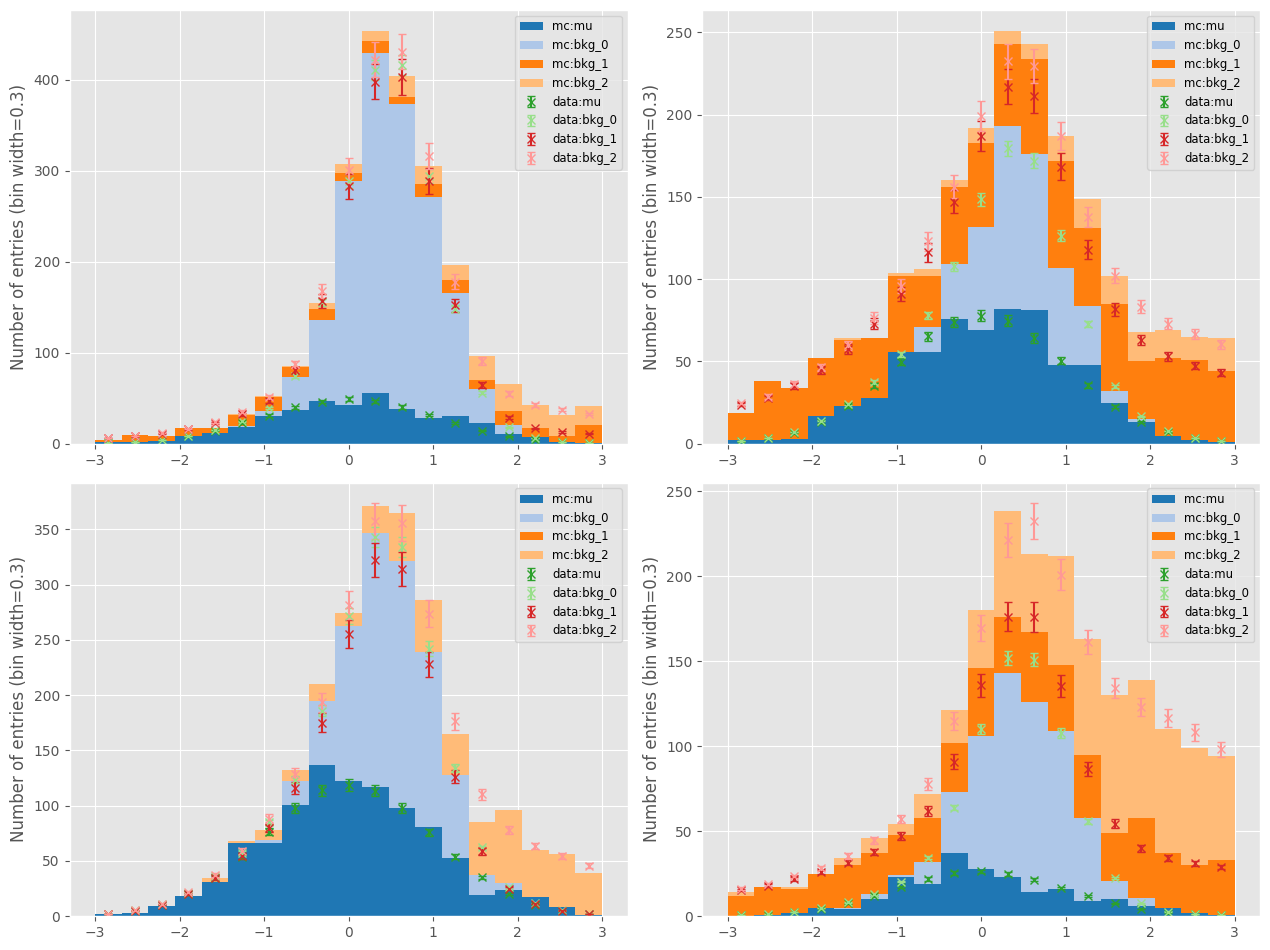

In [54]:
result = Fit(observations, model)
MakePlots(data, result, n_regions, n_background, model)

In [ ]:
def CalculatePulls(n_experiments):
    pull = []
    for n in range(n_experiments):
        ex = CreateDataSet(12, n_regions, n_background, 2500, bins)
        observations = GenerateObservations(ex, n_regions, model, verbose = False)
        result = Fit(observations, model, verbose = False)
        pull.append(((normalisation * result[:, 0]) - 1) / (normalisation * result[:, 1]))
    return np.array(pull)

pulls = CalculatePulls(1000)

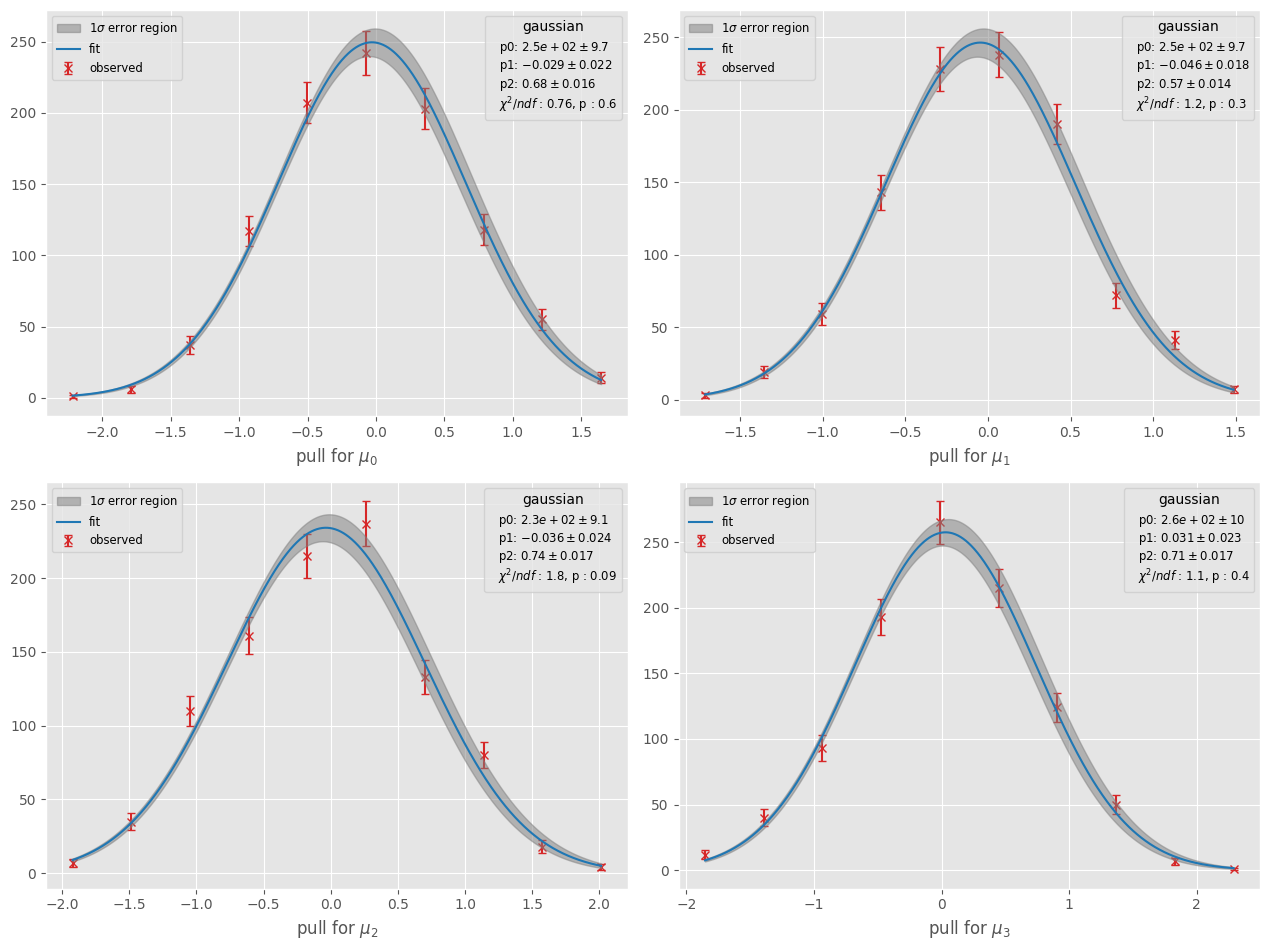

In [ ]:
from python.analysis import Fitting
for i in Plots.MultiPlot(4):
    y, x = np.histogram(pulls[:, i], bins = 10)
    x = (x[1:] + x[:-1]) / 2
    # print(f"{np.mean(pulls[:, i])=}")
    # print(f"{np.std(pulls[:, i])=}")
    Fitting.Fit(x, y, np.sqrt(y), Fitting.gaussian, plot = True, method = "trf", xlabel = f"pull for $\mu_{i}$")
    # Plots.PlotHist(pulls[:, i], newFigure = False)

# MC stat uncertainty

400.0

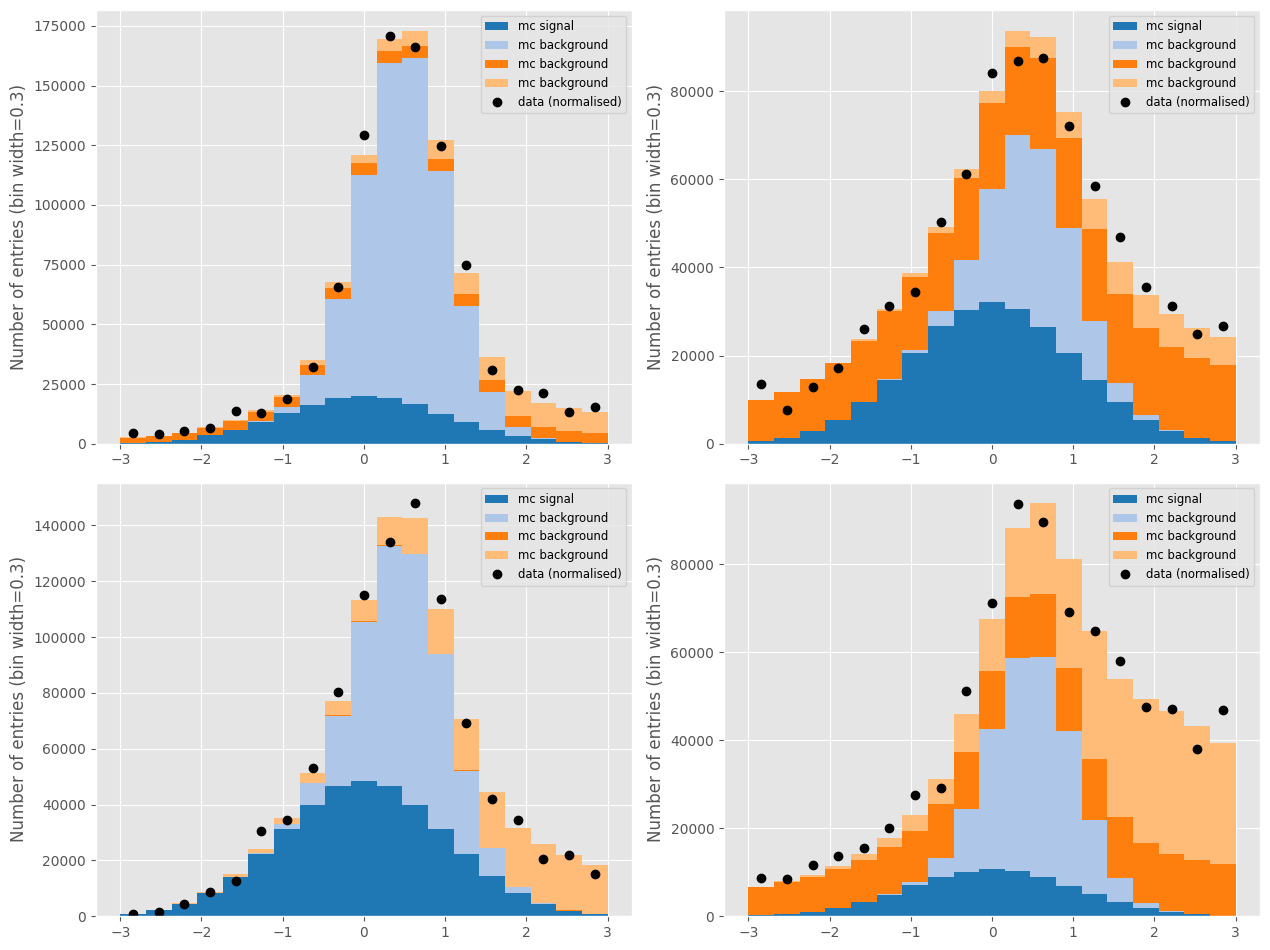

In [55]:
def channel(num : int, signal_data : np.array, background_data : list[np.array]):
    return {
        "name": f"channel_{num}",
        "samples":[
            {
                "name" : "signal",
                "data" : signal_data,
                "modifiers" : [
                    {'name': "mu", 'type': 'normfactor', 'data': None},
                    {'name': f"sig_stat_err_{num}", 'type': 'staterror', 'data': np.sqrt(signal_data)}
                    ]
            },
        ]+[
            {
                "name" : f"background_{num}_{b}",
                "data" : background_data[b],
                "modifiers" : [
                    {'name': f"bkg_{b}", 'type': 'normfactor', 'data': None},
                    {'name': f"bkg_stat_err_{num}_{b}", 'type': 'staterror', 'data': np.sqrt(background_data[b])}
                    ]
            }
        for b in range(len(background_data))
        ]
    }

bins = np.linspace(-3, 3, 20)
centers = (bins[1:] + bins[:-1])/2

n_regions = 4
n_background = 3
mc = CreateDataSet(12, n_regions, n_background, int(1E6), bins) # make this once

data = CreateDataSet(12, n_regions, n_background, 2500, bins)

normalisation = int(1E6) / 2500
print(normalisation)

for n in Plots.MultiPlot(n_regions):
    Plots.PlotHist(mc[f"region_{n}"], bins = bins, stacked = True, label = ["mc signal"] + ["mc background"] * n_background, newFigure = False)
    Plots.Plot(centers, data[f"region_{n}_combined"] * normalisation, marker = "o", color = "black", linestyle = "", label = "data (normalised)", newFigure = False)

spec = {"channels" : [
    channel(n, mc[f"region_{n}_binned"][0], mc[f"region_{n}_binned"][1:])
    for n in range(n_regions)]}
model = pyhf.Model(spec = spec)


In [56]:
PrintModelSpecs(model)
observations = GenerateObservations(data, n_regions, model)

channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']

nbins: {'channel_0': 19, 'channel_1': 19, 'channel_2': 19, 'channel_3': 19}

samples: ['background_0_0', 'background_0_1', 'background_0_2', 'background_1_0', 'background_1_1', 
'background_1_2', 'background_2_0', 'background_2_1', 'background_2_2', 'background_3_0', 'background_3_1', 
'background_3_2', 'signal']

modifiers: [('bkg_0', 'normfactor'), ('bkg_1', 'normfactor'), ('bkg_2', 'normfactor'), ('bkg_stat_err_0_0', 
'staterror'), ('bkg_stat_err_0_1', 'staterror'), ('bkg_stat_err_0_2', 'staterror'), ('bkg_stat_err_1_0', 
'staterror'), ('bkg_stat_err_1_1', 'staterror'), ('bkg_stat_err_1_2', 'staterror'), ('bkg_stat_err_2_0', 
'staterror'), ('bkg_stat_err_2_1', 'staterror'), ('bkg_stat_err_2_2', 'staterror'), ('bkg_stat_err_3_0', 
'staterror'), ('bkg_stat_err_3_1', 'staterror'), ('bkg_stat_err_3_2', 'staterror'), ('mu', 'normfactor'), 
('sig_stat_err_0', 'staterror'), ('sig_stat_err_1', 'staterror'), ('sig_stat_err_2', 'staterror'), 
('sig_stat_err_3', 'staterror')]

parameters: ['bkg_0', 'bkg_1', 'bkg_2', 'bkg_stat_err_0_0', 'bkg_stat_err_0_1', 'bkg_stat_err_0_2', 
'bkg_stat_err_1_0', 'bkg_stat_err_1_1', 'bkg_stat_err_1_2', 'bkg_stat_err_2_0', 'bkg_stat_err_2_1', 
'bkg_stat_err_2_2', 'bkg_stat_err_3_0', 'bkg_stat_err_3_1', 'bkg_stat_err_3_2', 'mu', 'sig_stat_err_0', 
'sig_stat_err_1', 'sig_stat_err_2', 'sig_stat_err_3']

nauxdata: 304

auxdata: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-3418639.88045056])

model.config.poi_index=3

result=array([[2.46392931e-03, 6.70837987e-05],
       [2.71611567e-03, 1.20501040e-04],
       [2.40793761e-03, 1.13034564e-04],
       [2.50276969e-03, 1.07455384e-04],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [9.99872363e-01, 9.81581107e-01],
       [1.00083652e+00, 1.92317528e-01],
       [9.99739832e-01, 5.33718423e-02],
       [9.99749965e-01, 1.96542991e-02],
       [9.99785373e-01, 8.95012355e-03],
       [9.99929075e-01, 4.90343119e-03],
       [1.00018712e+00, 3.28641328e-03],
       [1.00004651e+00, 2.66670354e-03],
       [9.99926780e-01, 2.62450527e-03],
       [9.99982538e-01, 3.13476808e-03],
       [1.00012673e+00, 4.54195234e-03],
       [9.99626955e-01, 7.97508986e-03],
       [1.00004715e+00, 1.69190907e-02],
       [1.00055829e+00, 4.31096605e-02],
       [9.99729784e-01, 1.38625156e-01],
       [1.00044134e+00, 5.73795342e-01],
       [1.00148115e+00, 2.08770344e-02],
       [1.00025039e+00, 2.00505227e-02],
       [1.00015441e+00, 1.88142978e-02],
       [9.99863559e-01, 1.77979828e-02],
       [1.00092364e+00, 1.66806750e-02],
       [9.99712656e-01, 1.61444072e-02],
       [9.99723550e-01, 1.54872707e-02],
       [9.99762287e-01, 1.52900758e-02],
       [9.99920397e-01, 1.47910713e-02],
       [1.00020463e+00, 1.43775762e-02],
       [1.00004958e+00, 1.42185595e-02],
       [9.99917610e-01, 1.42013781e-02],
       [9.99979110e-01, 1.41019290e-02],
       [1.00013819e+00, 1.40095192e-02],
       [9.99587593e-01, 1.41737637e-02],
       [1.00005113e+00, 1.42620566e-02],
       [1.00061490e+00, 1.45162805e-02],
       [9.99702400e-01, 1.50339235e-02],
       [1.00049844e+00, 1.55053269e-02],
       [1.00131073e+00, 1.82458441e-01],
       [1.00022108e+00, 1.32407685e-01],
       [1.00013660e+00, 9.01506809e-02],
       [9.99879180e-01, 6.57875882e-02],
       [1.00081882e+00, 5.04380320e-02],
       [9.99745752e-01, 3.86882578e-02],
       [9.99755502e-01, 2.97066782e-02],
       [9.99789919e-01, 2.34840730e-02],
       [9.99930099e-01, 1.96219786e-02],
       [1.00018204e+00, 1.65605589e-02],
       [1.00004463e+00, 1.40994391e-02],
       [9.99927678e-01, 1.24106431e-02],
       [9.99982198e-01, 1.13497171e-02],
       [1.00012322e+00, 1.05569740e-02],
       [9.99635278e-01, 1.00696448e-02],
       [1.00004622e+00, 9.88353071e-03],
       [1.00054600e+00, 9.91228823e-03],
       [9.99737209e-01, 1.02532092e-02],
       [1.00044280e+00, 1.07832104e-02],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [9.99708459e-01, 9.81578421e-01],
       [1.00010158e+00, 2.66907894e-01],
       [9.99938993e-01, 9.66565657e-02],
       [9.99648989e-01, 3.69847275e-02],
       [9.99989099e-01, 1.69477439e-02],
       [9.99904776e-01, 9.34065686e-03],
       [1.00008308e+00, 6.22589596e-03],
       [9.99793756e-01, 5.03768296e-03],
       [9.99851483e-01, 4.97480102e-03],
       [9.99860864e-01, 5.92947874e-03],
       [1.00007047e+00, 8.59619187e-03],
       [1.00023540e+00, 1.51165536e-02],
       [1.00002899e+00, 3.18448511e-02],
       [1.00003337e+00, 7.95459389e-02],
       [9.99738120e-01, 4.06989512e-01],
       [1.00000000e+00, 0.00000000e+00],
       [1.00074306e+00, 1.03845418e-02],
       [9.98917855e-01, 9.80775892e-03],
       [9.99497410e-01, 9.22224306e-03],
       [9.99682652e-01, 8.78709376e-03],
       [1.00011519e+00, 8.44333157e-03],
       [9.99932830e-01, 8.03128586e-03],
       [9.99612580e-01, 7.76638779e-03],
       [9.99987394e-01, 7.50266471e-03],
       [9.99894251e-01, 7.32771427e-03],
       [1.00009063e+00, 7.17522727e-03],
       [9.99771559e-01, 7.06914979e-03],
       [9.99835185e-01, 6.97818339e-03],
       [9.99845627e-01, 6.99015910e-03],
       [1.00007693e+00, 6.94658115e-03],
       [1.00025902e+00, 7.02762707e-03],
       [1.00003167e+00, 7.09669701e-03],
       [1.00003686e+00, 7.26413174e-03],
       [9.997183

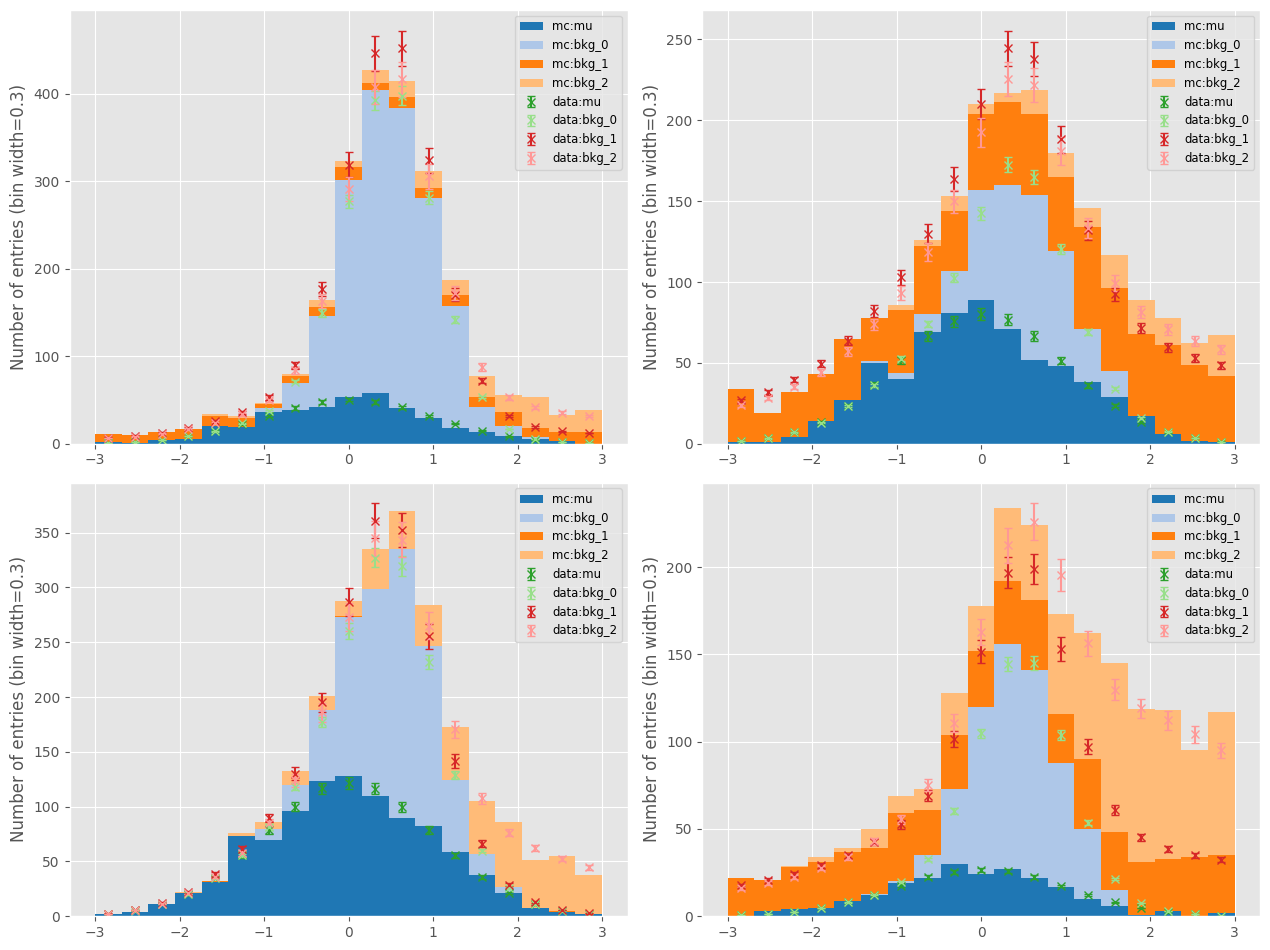

In [57]:
result = Fit(observations, model)
MakePlots(data, result, n_regions, n_background, model)

In [126]:
pulls = CalculatePulls(100, n_regions, model)
print(pulls)

TypeError: CalculatePulls() missing 2 required positional arguments: 'n_regions' and 'model'

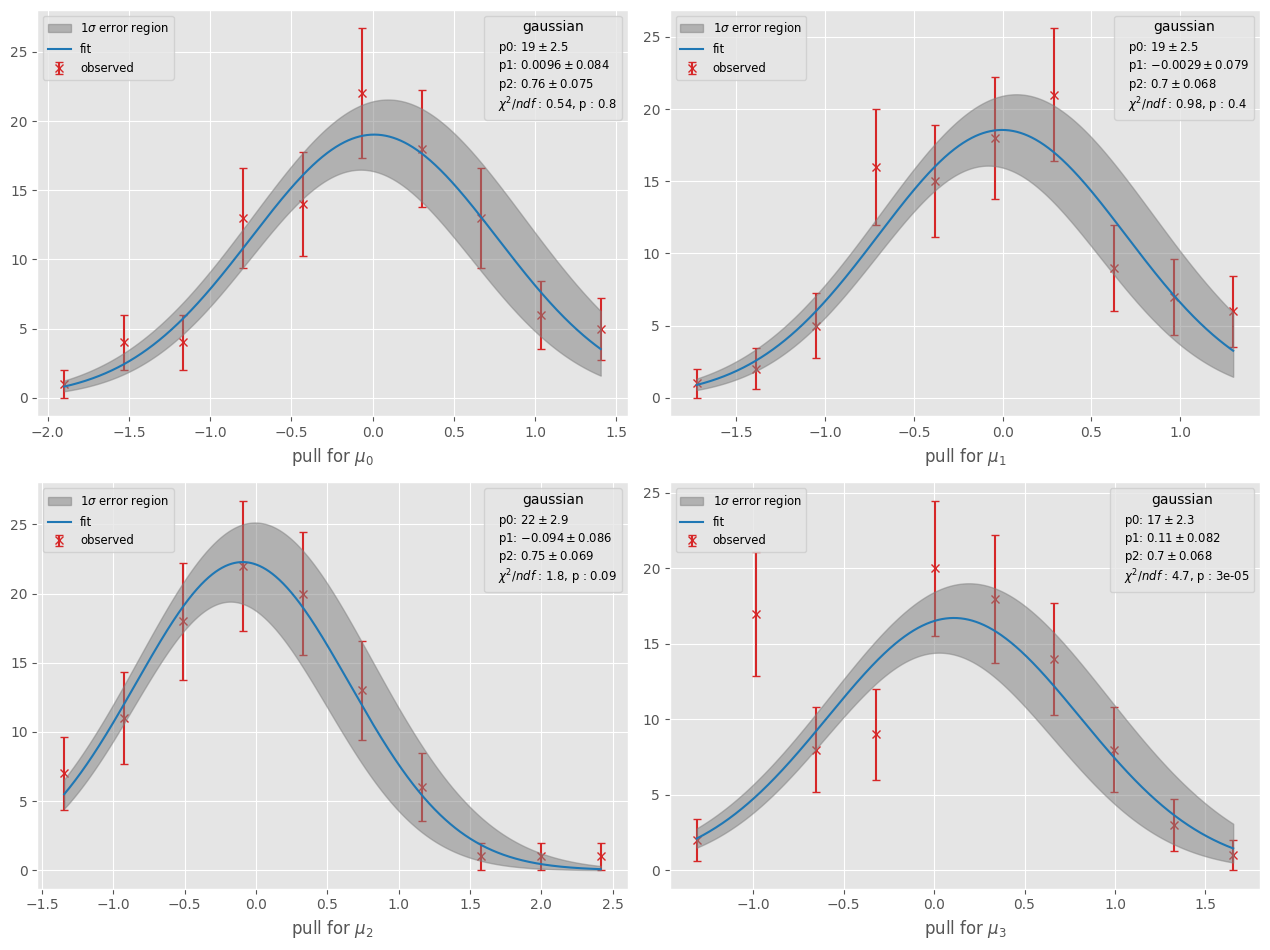

In [96]:
from python.analysis import Fitting
for i in Plots.MultiPlot(4):
    y, x = np.histogram(pulls[:, i], bins = 10)
    x = (x[1:] + x[:-1]) / 2
    # print(f"{np.mean(pulls[:, i])=}")
    # print(f"{np.std(pulls[:, i])=}")
    Fitting.Fit(x, y, np.sqrt(y), Fitting.gaussian, plot = True, method = "trf", xlabel = f"pull for $\mu_{i}$")
    # Plots.PlotHist(pulls[:, i], newFigure = False)

In [103]:
print(np.mean(pulls, 0))
print(np.std(pulls, 0))
print(np.std(pulls, 0)/np.sqrt(100-1))

[-0.04889921 -0.00911082 -0.00516872  0.02684968]

[0.73386053 0.66391162 0.76583279 0.68392749]

[0.07375576 0.06672563 0.07696909 0.0687373 ]

# Toy Model

In [3]:
import pandas as pd

def ToyRecoQuantities(toy : pd.DataFrame) -> pd.DataFrame:
    smeared = {}
    for q in ["z_int","KE_init", "KE_int"]:
        s = toy.filter(regex = q)
        smeared[f"{q}_smeared"] = s.iloc[:, 0] + s.iloc[:, 1]
    return pd.DataFrame(smeared)

toy = pd.read_hdf("work/2023/toys/xs_toy_1GeV_gaussian_60MeV.hdf5")
toy = pd.concat([toy, ToyRecoQuantities(toy)], axis = 1)
toy.head()

,KE_init,KE_int,z_int,inclusive_process,exclusive_process,absorption,charge_exchange,double_charge_exchange,pion_production,quasielastic,...,reco_regions_charge_exchange,reco_regions_single_pion_production,reco_regions_pion_production,truth_regions_absorption,truth_regions_charge_exchange,truth_regions_single_pion_production,truth_regions_pion_production,z_int_smeared,KE_init_smeared,KE_int_smeared
0,909.190834,889.359165,9.0,total_inelastic,absorption,True,False,False,False,False,...,False,False,False,True,False,False,False,21.638652,902.895740,998.755033
1,904.330491,837.310713,30.5,total_inelastic,quasielastic,False,False,False,False,True,...,False,False,False,False,False,True,False,15.866633,899.539169,805.964996
2,902.235948,798.076715,47.5,total_inelastic,quasielastic,False,False,False,False,True,...,False,True,False,False,False,True,False,48.509617,844.991826,820.754454
3,785.834295,768.421353,8.0,total_inelastic,quasielastic,False,False,False,False,True,...,False,False,False,False,False,True,False,7.955258,758.439491,703.912846
4,876.636799,755.354927,55.5,total_inelastic,pion_production,False,False,False,True,False,...,False,False,False,False,False,False,True,57.181669,909.378183,640.846427


In [4]:
toy_model_input = toy.iloc[:int(len(toy)/2),:]
toy_observed = toy.iloc[int(len(toy)/2):,:]

In [5]:
bins = np.linspace(0, 1050, 12)
model_input_data = []
for c in toy_model_input.filter(regex = "reco_regions"):
    tmp = []
    for s in toy_model_input.filter(regex = "truth_regions"):
        tmp.append(np.histogram(toy_model_input.KE_int[toy_model_input[c] & toy_model_input[s]], bins = bins)[0])
    model_input_data.append(tmp)

In [6]:
model = CreateModel(len(model_input_data), model_input_data, True)
PrintModelSpecs(model)

channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']

nbins: {'channel_0': 11, 'channel_1': 11, 'channel_2': 11, 'channel_3': 11}

samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']

modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor'), 
('sample_stat_err_0', 'staterror'), ('sample_stat_err_1', 'staterror'), ('sample_stat_err_2', 'staterror'), 
('sample_stat_err_3', 'staterror')]

parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3', 'sample_stat_err_0', 'sample_stat_err_1', 'sample_stat_err_2', 
'sample_stat_err_3']

nauxdata: 176

auxdata: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [7]:
def GenerateObservations(data, model, verbose : bool = True):
    if verbose is True: print(f"{model.config.suggested_init()=}")
    observations = np.concatenate(data + [model.config.auxdata])
    if verbose is True: print(f"{model.logpdf(pars=model.config.suggested_init(), data=observations)=}")
    return observations

toy_observed_binned = []
for c in toy_observed.filter(regex = "reco_regions"):
    toy_observed_binned.append(np.histogram(toy_observed.KE_int[toy_observed[c]], bins = bins)[0])
observed = GenerateObservations(toy_observed_binned, model)

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0]

model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-729.67152505])

In [8]:
result = Fit(observed, model)

model.config.poi_index=0

result=array([[0.97005105, 0.01306415],
       [1.02032957, 0.02157147],
       [1.14040633, 0.01521398],
       [1.03893278, 0.03175997],
       [1.02732102, 0.03024446],
       [0.99950701, 0.01791826],
       [0.98195415, 0.01415864],
       [0.99502788, 0.01092693],
       [0.996765  , 0.00921869],
       [1.00354424, 0.00807455],
       [1.00095027, 0.00696089],
       [1.00277078, 0.00613495],
       [1.00311122, 0.00625321],
       [0.99997792, 0.01021417],
       [1.01544157, 0.04099818],
       [1.        , 0.        ],
       [0.85260017, 0.97541218],
       [0.92240917, 0.44095633],
       [1.01987146, 0.980719  ],
       [0.92649645, 0.57251691],
       [0.96996297, 0.57320664],
       [0.99496467, 0.37658501],
       [0.98496495, 0.37676507],
       [1.00103215, 0.33248427],
       [0.99849568, 0.70037787],
       [1.        , 0.        ],
       [1.03716982, 0.06566247],
       [0.98375058, 0.037881  ],
       [0.98699758, 0.03028488],
       [0.99924963, 0.02292018],
       [0.99809067, 0.01930205],
       [0.99918366, 0.01690888],
       [0.99585267, 0.01428481],
       [1.00590344, 0.01265235],
       [0.99903676, 0.01273705],
       [0.99901929, 0.02123652],
       [0.99954355, 0.0740965 ],
       [0.9133259 , 0.11006521],
       [0.93176865, 0.06686769],
       [0.94298078, 0.05313266],
       [0.97750874, 0.04530857],
       [1.01149968, 0.03798678],
       [0.98984842, 0.03318068],
       [0.98302833, 0.02814899],
       [0.99156319, 0.02481048],
       [0.99690905, 0.02549977],
       [0.98445924, 0.04254819],
       [1.00307199, 0.1435504 ],
       [1.02870424, 0.17751076],
       [0.99946739, 0.05897199],
       [0.98096428, 0.03785876],
       [0.99475403, 0.02810754],
       [0.99659798, 0.01962517],
       [1.00372604, 0.01470859],
       [1.0009926 , 0.01076872],
       [1.00290992, 0.00798512],
       [1.00327271, 0.00726707],
       [0.99997825, 0.01121832],
       [1.01623536, 0.03666282],
       [0.80664198, 0.23420321],
       [0.84562444, 0.10937785],
       [0.91844157, 0.08180602],
       [1.02103167, 0.06291116],
       [0.92269385, 0.0446804 ],
       [0.96841916, 0.03317918],
       [0.99469847, 0.02623236],
       [0.98422929, 0.02034902],
       [1.00107425, 0.01867562],
       [0.99841917, 0.0279698 ],
       [0.90599839, 0.08636511],
       [1.03911411, 0.49519333],
       [0.98288618, 0.14615869],
       [0.98631416, 0.10336648],
       [0.99923134, 0.0755142 ],
       [0.99801015, 0.05331649],
       [0.99916168, 0.04053245],
       [0.99565812, 0.03013027],
       [1.00622149, 0.02221655],
       [0.99899043, 0.02024474],
       [0.99896155, 0.03111891],
       [0.99950309, 0.1159544 ],
       [1.        , 0.        ],
       [0.92815597, 0.26309523],
       [0.93996319, 0.23334128],
       [0.97631108, 0.14855527],
       [1.01211797, 0.11297367],
       [0.98933756, 0.07820322],
       [0.98216724, 0.06233599],
       [0.99113832, 0.04374049],
       [0.99675882, 0.04306972],
       [0.98365914, 0.05928766],
       [1.00323101, 0.2101139 ],
       [1.03207833, 0.15132154],
       [0.99940058, 0.03811063],
       [0.97871593, 0.02571008],
       [0.99413101, 0.02139361],
       [0.99619271, 0.01639558],
       [1.00416462, 0.01185445],
       [1.00111367, 0.00878644],
       [1.00325858, 0.00679201],
       [1.00366492, 0.00597095],
       [0.999986  , 0.0086378 ],
       [1.01815268, 0.02892005],
       [1.        , 0.        ],
       [0.82628874, 0.33753082],
       [0.90864657, 0.24693003],
       [1.02341919, 0.22784402],
       [0.9135316 , 0.16406334],
       [0.96470917, 0.12707316],
       [0.99408244, 0.08121216],
       [0.98233708, 0.07233169],
       [1.00121794, 0.06349251],
       [0.99824044, 0.09072694],
       [0.89483888, 0.3085304 ],
       [1.04375169, 0.14334056],
       [0.98085814, 0.03203442],
       [0.98465817, 0.0217121 ],
       [0.99906449, 0.01796556],
       [0.99771239, 0.01380504],
       [0.99902669, 0.0102409 ],
       [0.99513351, 0.00762473],


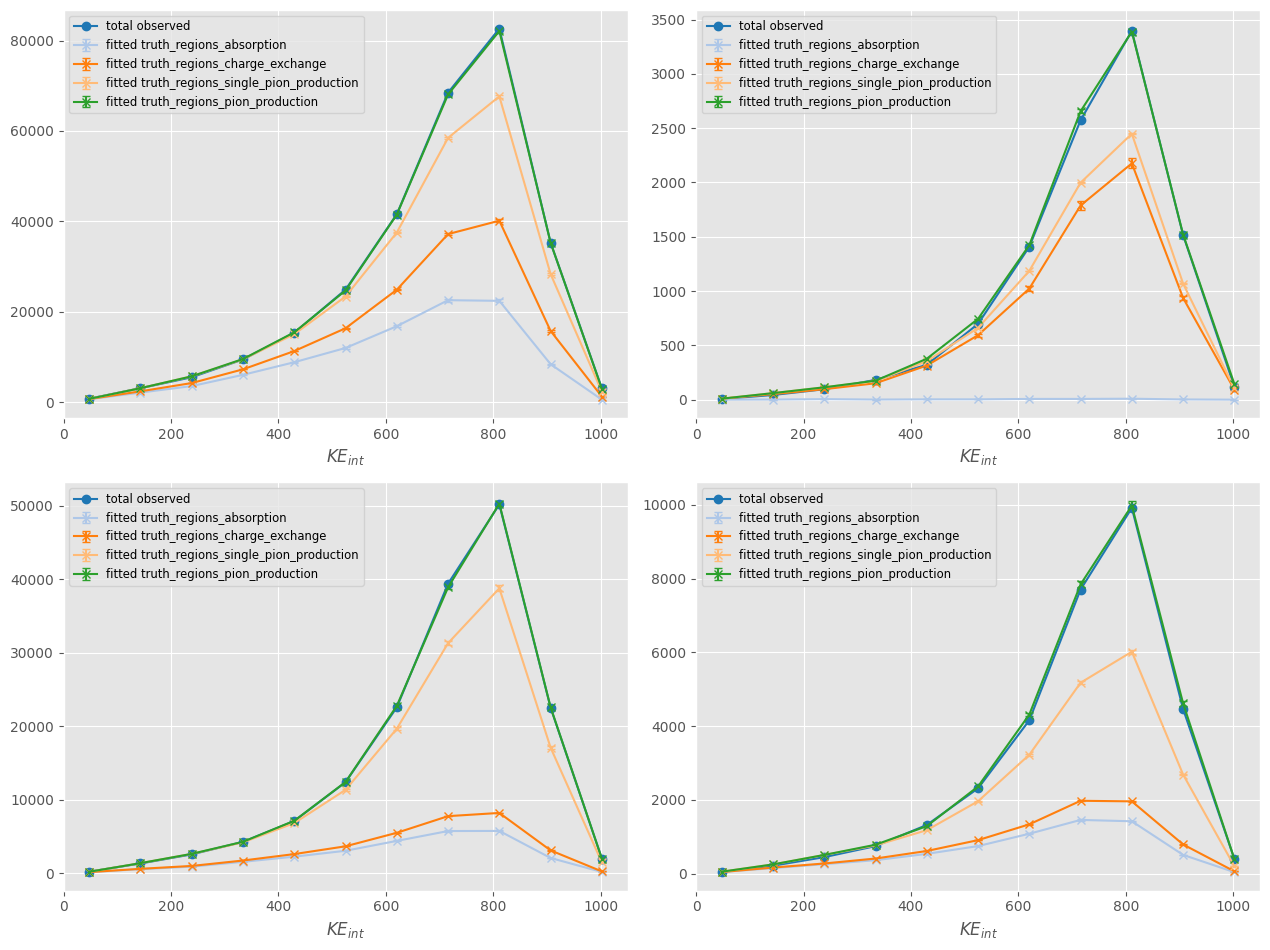

In [9]:
x = (bins[1:] + bins[:-1])/2
for i, d in Plots.IterMultiPlot(toy_model_input.filter(regex = "reco_regions").columns):
    Plots.Plot(x, toy_observed_binned[i], marker = "o", label = "total observed", newFigure = False)

    labels = toy_model_input.filter(regex = "truth_regions").columns

    plot_data = [np.histogram(toy_model_input[toy_model_input[d] & toy_model_input[m]].KE_int, bins = bins)[0] for m in toy_model_input.filter(regex = "truth_regions")]
    counts = np.zeros(len(plot_data[0]))
    for e, (i, mu) in enumerate(zip(plot_data, result)):
        counts = counts + (i * mu[0])
        Plots.Plot(x, counts, yerr = i * mu[1], marker = "x", xlabel = "$KE_{int}$", label = f"fitted {labels[e]}", newFigure = False)

In [84]:
tmp = {"sample_0" : np.array([0, 1, 2, 3, 4]), "sample_1" : np.array([True, False, True, False, False])}

mask not needed

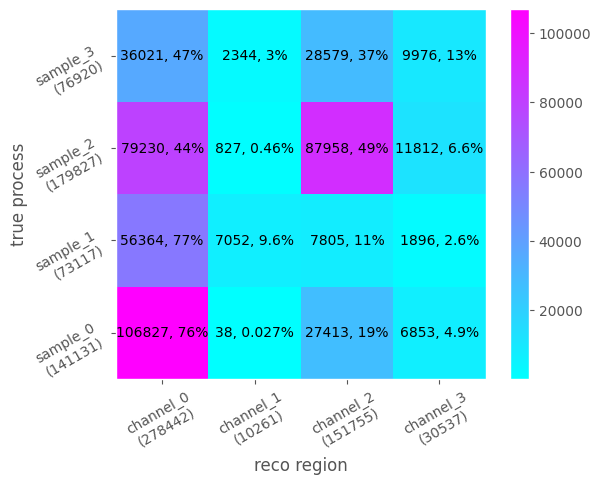

In [85]:
mu = result[0:4]

counts_matrix = []
for channel in model.spec["channels"]:
    counts = []
    for sample in channel["samples"]:
        counts.append(sum(sample["data"]))
    counts_matrix.append(counts)
counts_matrix = np.array(counts_matrix).T

In [70]:
np.set_printoptions(suppress=True)
print(counts_matrix)

print(np.sum(counts_matrix, axis = 1))

print(counts_matrix / np.sum(counts_matrix, axis = 1)[:, np.newaxis])

for i, j in zip(counts_matrix, np.sum(counts_matrix, axis = 1)):
    print(i/j)

[[106827     38  27413   6853]
 [ 56364   7052   7805   1896]
 [ 79230    827  87958  11812]
 [ 36021   2344  28579   9976]]

[141131  73117 179827  76920]

[[0.75693505 0.00026925 0.19423798 0.04855772]
 [0.77087408 0.09644816 0.10674672 0.02593104]
 [0.44059012 0.00459886 0.48912566 0.06568535]
 [0.46829173 0.03047322 0.37154186 0.12969319]]

[0.75693505 0.00026925 0.19423798 0.04855772]

[0.77087408 0.09644816 0.10674672 0.02593104]

[0.44059012 0.00459886 0.48912566 0.06568535]

[0.46829173 0.03047322 0.37154186 0.12969319]